# Identifying Substructures with Persistent Homology

In this notebook we are going to identify important substruactures of the fold switching KaiB protein. Using persistent homology informed DBSCAN, we will extract substructures which the model identifies as important. See the paper [Prediction of multiple conformational states by combining sequence clustering with AlphaFold2](https://www.biorxiv.org/content/10.1101/2022.10.17.512570v1). 

In [1]:
# Let's start by importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd
from transformers import EsmModel, AutoTokenizer
import torch
from scipy.spatial.distance import pdist, euclidean, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from gudhi.hera import wasserstein_distance

In [2]:
# Helper function to get the hidden states of a specific layer for a given input sequence
def get_hidden_states(tokenizer, model, layer, input_sequence):
    model.config.output_hidden_states = True
    encoded_input = tokenizer([input_sequence], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    hidden_states = model_output.hidden_states
    specific_hidden_states = hidden_states[layer][0]
    return specific_hidden_states


def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    gd.plot_persistence_diagram(persistence=persistent_homology)

    plt.show()

In [3]:
sequences = ["MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"]

In [4]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Set the layer and head to use for computation
layer = 5

# Compute the context vectors for each text in the corpus
context = [get_hidden_states(tokenizer, model, layer, sequence) for sequence in sequences]
print(context[0].shape)
print(context[0])

torch.Size([110, 320])
tensor([[ 1.6001,  4.0113,  0.7532,  ...,  1.4542,  1.0744, -3.3903],
        [ 1.5641,  0.3285, -1.9449,  ...,  1.2518,  0.1108,  0.3009],
        [ 2.5461,  0.0636, -0.7479,  ...,  1.0973, -0.3859,  0.4713],
        ...,
        [-0.6584, -0.9762,  1.4164,  ...,  2.4608, -1.7029, -1.3402],
        [ 1.6369, -2.0765,  0.0539,  ...,  0.0288, -1.4559,  0.4197],
        [-0.0170, -0.0175, -0.3287,  ...,  0.6505, -5.6772, -2.9762]])


Barcode for text 0:


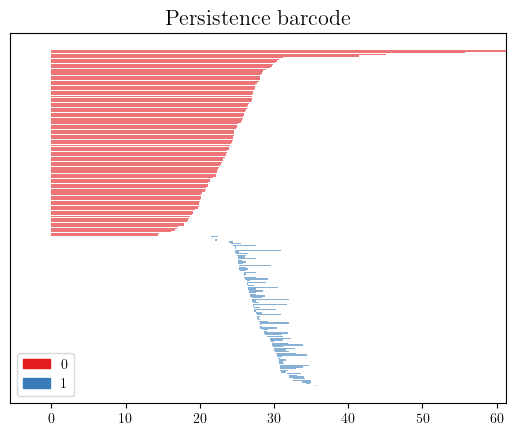

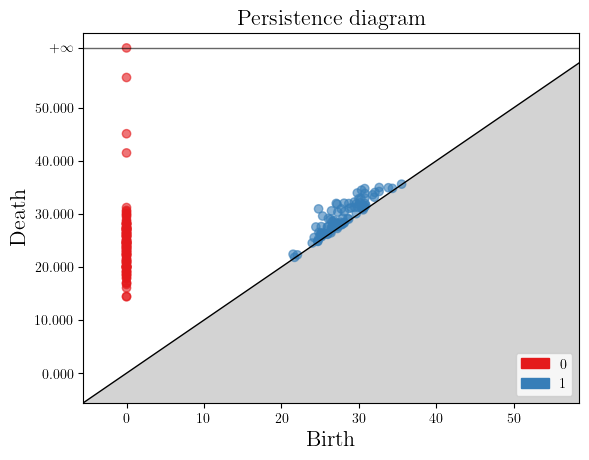

In [6]:
# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [22]:
def cluster_and_get_positions(context, sentence, eps):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append((tokens[i], i))  # Store both the token and its position

    return clusters


# Compute the clusters for each context vector
#clusters = []
#for i, output in enumerate(context):
    #print(f"Clusters for text {i}:")
    #clusters.append(cluster_and_get_positions(output, text[i], 0.7))
    #for label, words in clusters[-1].items():
    #    print(f"Cluster {label}: {', '.join(word for word, _ in words)}")

# Assuming you want to get the positions of the tokens in the first cluster of the first text:
# cluster_number = 7  # Change this to the desired cluster number
#text_number = 0  # Change this to the desired text number


# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_positions(output, sequences[i], 22.0))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(f'{word} {position}' for word, position in words)}")



Clusters for text 0:
Cluster 0: L 25, L 28, L 32
Cluster 1: V 44, V 47
Cluster 2: L 53, L 60, L 65, L 69, L 80, L 87, L 90, L 92, L 93
Cluster 3: A 54, A 61, A 66
Cluster 4: E 55, E 56, E 84, E 95, E 96, E 102, E 108
Cluster 5: K 58, K 67
Cluster 6: I 59, I 76, I 77, I 97
Cluster 7: P 63, P 70, P 71, P 72
Cluster 8: V 68, V 73, V 86
Cluster 9: R 74, R 75
Cluster 10: G 78, G 98, G 106
Cluster 11: D 91, D 99, D 103, D 104
Cluster 12: L 105, L 107


In [23]:
# Specify the text number and cluster number you're interested in
text_number = 0  # Change this to the desired text number
cluster_number = 2  # Change this to the desired cluster number

# Retrieve the positions of the tokens in the specified cluster
cluster_positions = [position for _, position in clusters[text_number].get(cluster_number, [])]

print(f"Positions of the tokens in cluster {cluster_number} of text {text_number}: {cluster_positions}")


Positions of the tokens in cluster 2 of text 0: [53, 60, 65, 69, 80, 87, 90, 92, 93]


In [13]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)

import os, time
if not os.path.isfile("esmfold.model"):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

  # install libs
  os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol")
  os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

  # install openfold
  commit = "6908936b68ae89f67755240e2f588c09ec31d4c8"
  os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

  # install esmfold
  os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")

  # wait for Params to finish downloading...
  if not os.path.isfile("esmfold.model"):
    # backup source!
    os.system("aria2c -q -x 16 https://files.ipd.uw.edu/pub/esmfold/esmfold.model")
  else:
    while os.path.isfile("esmfold.model.aria2"):
      time.sleep(5)

CPU times: user 44 µs, sys: 259 µs, total: 303 µs
Wall time: 795 µs


In [15]:
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from transformers import AutoTokenizer, EsmForProteinFolding

model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test"
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir():
  import torch
  model = torch.load("esmfold.model")
  model.eval().cuda().requires_grad_(False)

torch.cuda.empty_cache()
# removed the num_recycles argument from the call to infer
output = model.infer(sequence)#,
                     #chain_linker="X"*chain_linker,
                     #residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = {k: v.cpu().numpy() for k, v in output.items()}
ptm = output["ptm"]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


length 108
ptm: 0.280 plddt: 0.404


In [24]:
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]


def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False, highlight_residues=None):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  view.setBackgroundColor('black')  # Set the background color to black
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  # Highlight specific residues
  if highlight_residues is not None:
    for pos in highlight_residues:
      view.setStyle({'resi': pos}, {'stick': {'colorscheme': 'magentaCarbon'}})

  view.zoomTo()
  if animate: view.animate()
  return view

color = "chain" 
if color == "confidence": color = "pLDDT"
show_sidechains = False
show_mainchains = True
highlight_residues = [53, 60, 65, 69, 80, 87, 90, 92, 93]  # Add this line to specify the residues to highlight
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths,
         highlight_residues=highlight_residues).show()  # Add the highlight_residues argument here


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol